In [1]:
# Import libraries
import numpy as np
import random
import cv2
import os
import glob
import matplotlib.pyplot as plt

import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.preprocessing.image import img_to_array
from keras.utils import to_categorical, plot_model
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.layers import BatchNormalization, Conv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense
from keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report,ConfusionMatrixDisplay

In [2]:
# Configurations
batch_size = 64
epochs = 100
img_dims = (96,96,3)
#lr = 1e-3

In [3]:
# Specify the directory containing image files
directory_path = '/Users/ronja/Desktop/DS22_EC/8_Deep_Learning/Kunskapskontoller_DL/Kunskapskontroll_2/GenderDetection/gender_dataset_face'

# Find all files in the specified directory and its subdirectories
all_files = glob.glob(directory_path + '/**/*', recursive=True)

# Create a list to store file paths (excluding directories)
image_files = [file_path for file_path in all_files if not os.path.isdir(file_path)]

# Shuffle the list of image files randomly
random.shuffle(image_files)

In [4]:
# Create lists to contain data
data = []
labels = []

# Converting images to arrays and labelling the categories
for img in image_files:
    image = cv2.imread(img)
    image = cv2.resize(image, (96, 96))
    image = img_to_array(image)
    data.append(image)

    label = img.split(os.path.sep)[-2]
    if label == "woman":
        label = 1
    else:
        label = 0
        
    labels.append([label]) # [[1], [0], [0], ...]

In [5]:
# Convert list to np arrays
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)

# Check shape of the data
print("Shape of data:", data.shape)  
print("Shape of labels:", labels.shape)  

Shape of data: (2307, 96, 96, 3)
Shape of labels: (2307, 1)


In [6]:
# Split dataset for training and validation
(X_train, X_test, y_train, y_test) = train_test_split(data, labels, test_size=0.2, random_state=42)

In [7]:
y_train = to_categorical(y_train, num_classes=2) # [[1, 0], [0, 1], [0, 1], ...]
y_test = to_categorical(y_test, num_classes=2)

In [8]:
# Augmenting datset 
aug = ImageDataGenerator(rotation_range=25, width_shift_range=0.1,
                         height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
                         horizontal_flip=True, fill_mode="nearest")

In [9]:
# Model function - you can create a function to build a model instead of building each model from stratch 
def build_model(width, height, depth, classes):
    model = Sequential()
    inputShape = (height, width, depth)
    chanDim = -1

    if K.image_data_format() == "channels_first": #Returns a string, either 'channels_first' or 'channels_last'
        inputShape = (depth, height, width)
        chanDim = 1
    
    # The axis that should be normalized, after a Conv2D layer with data_format="channels_first", 
    # set axis=1 in BatchNormalization.

    model.add(Conv2D(32, (3,3), padding="same", input_shape=inputShape))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(3,3)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3,3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))

    model.add(Conv2D(64, (3,3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3,3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))

    model.add(Conv2D(128, (3,3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(1024))
    model.add(Activation("relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(classes))
    model.add(Activation("sigmoid"))

    return model

In [10]:
# Build model
gender_model = build_model(width=img_dims[0], height=img_dims[1], depth=img_dims[2], classes=2)

In [11]:
# Compile the model
gender_model.compile(loss="binary_crossentropy", optimizer='adam', metrics=["accuracy"])

In [12]:
# Model summary
gender_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 96, 96, 32)        896       
                                                                 
 activation (Activation)     (None, 96, 96, 32)        0         
                                                                 
 batch_normalization (Batch  (None, 96, 96, 32)        128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        1

In [13]:
# Train the model
gender_model_info = gender_model.fit(aug.flow(X_train, y_train, batch_size=batch_size),
                        validation_data=(X_test,y_test),
                        steps_per_epoch=len(X_test) // batch_size,
                        epochs=epochs, verbose=1,
                        )

Epoch 1/100
7/7 [==============================] - 3s 436ms/step - loss: 0.9571 - accuracy: 0.6406 - val_loss: 0.6838 - val_accuracy: 0.5390
Epoch 2/100
7/7 [==============================] - 3s 429ms/step - loss: 0.6717 - accuracy: 0.7522 - val_loss: 0.7010 - val_accuracy: 0.5390
Epoch 3/100
7/7 [==============================] - 3s 415ms/step - loss: 0.6499 - accuracy: 0.7790 - val_loss: 0.7961 - val_accuracy: 0.5390
Epoch 4/100
7/7 [==============================] - 3s 418ms/step - loss: 0.5267 - accuracy: 0.8170 - val_loss: 0.8971 - val_accuracy: 0.5390
Epoch 5/100
7/7 [==============================] - 3s 404ms/step - loss: 0.4968 - accuracy: 0.8170 - val_loss: 1.0143 - val_accuracy: 0.5390
Epoch 6/100
7/7 [==============================] - 3s 400ms/step - loss: 0.4201 - accuracy: 0.8307 - val_loss: 1.3005 - val_accuracy: 0.5390
Epoch 7/100
7/7 [==============================] - 3s 435ms/step - loss: 0.4366 - accuracy: 0.8259 - val_loss: 0.7917 - val_accuracy: 0.5390
Epoch 8/100
7

In [14]:
# Save the model in .h5 file
gender_model.save('/Users/ronja/Desktop/DS22_EC/8_Deep_Learning/Kunskapskontoller_DL/Kunskapskontroll_2/models/gender_model_100e.h5')

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


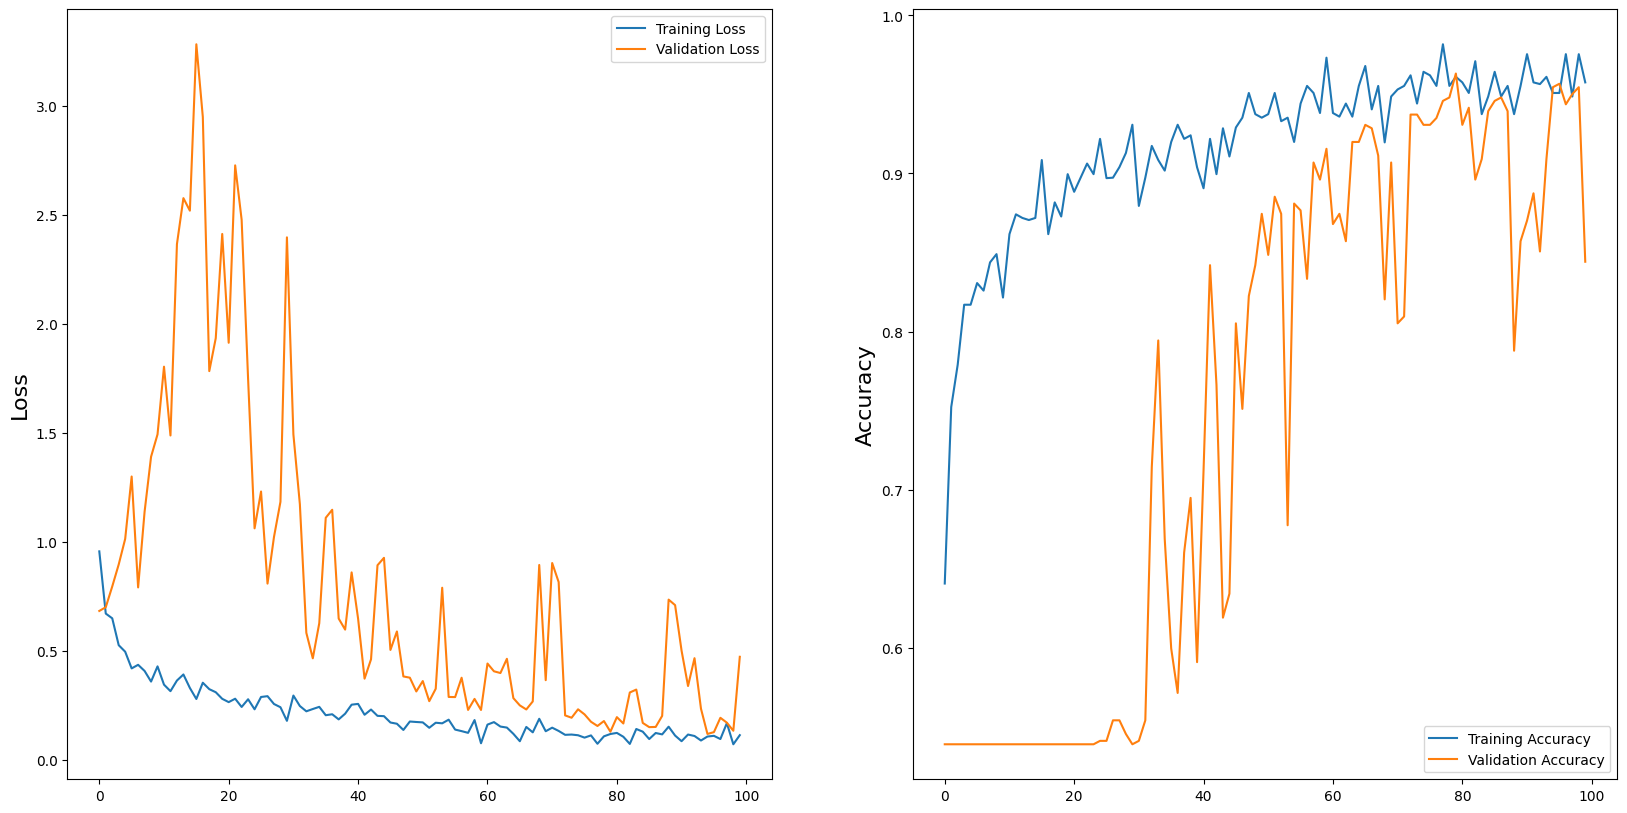

In [15]:
import matplotlib.pyplot as plt

# Plot accuracy score
plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.ylabel('Loss', fontsize=16)
plt.plot(gender_model_info.history['loss'], label='Training Loss')
plt.plot(gender_model_info.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(gender_model_info.history['accuracy'], label='Training Accuracy')
plt.plot(gender_model_info.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')

plt.show()